In [2]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import datetime
from datetime import datetime
from datetime import timedelta
import pickle


import warnings
warnings.filterwarnings(action='ignore') 

# 사이킷런
from sklearn.preprocessing import PolynomialFeatures
from sklearn.linear_model import LinearRegression

# 회귀
import statsmodels.api as sm
import statsmodels.formula.api as smf

In [3]:
# 사이킷런
from sklearn.preprocessing import PolynomialFeatures
from sklearn.linear_model import LinearRegression

# 회귀
import statsmodels.api as sm
import statsmodels.formula.api as smf

In [4]:
pd.set_option('display.max_row', 5000)
pd.set_option('display.max_columns', 100)

from matplotlib import font_manager, rc
import matplotlib
font_name = font_manager.FontProperties(fname="c:/Windows/Fonts/malgun.ttf").get_name()

rc('font', family=font_name)

matplotlib.rcParams['axes.unicode_minus'] = False

# 데이터 로드

In [4]:
sang18_tomato_raw=pd.read_excel('C:\\농업기술원\\1차\\2018\\2018-2019 토마토_생육(원본)'+'/오마이토마토_오길택_생육.xlsx',sheet_name='1819생육')

In [5]:
#env18_tomato_raw=pd.read_excel('C:\\농업기술원\\1차\\2018\\2018-2019 토마토_환경(원본)'+'/오마이토마토_오길택_환경.xlsx')

In [6]:
#with open("C:\\농업기술원\\1차\\2018\\2018-2019 토마토_환경(원본)\\오마이토마토_오길택_환경.pickle","wb") as fw:
#    pickle.dump(env18_tomato_raw, fw)

In [7]:
with open("C:\\농업기술원\\1차\\2018\\2018-2019 토마토_환경(원본)\\오마이토마토_오길택_환경.pickle","rb") as fr:
    env18_tomato_raw = pickle.load(fr)

In [36]:
name='오마이_ㅇㄱㅌ'

# 필요한 데이터 컬럼 고르기

In [8]:
sang_data=sang18_tomato_raw[['Date','WeekNum','Sample','초장','생장길이','화방높이','줄기굵기']]

In [9]:
env_data=env18_tomato_raw[['date','내부온도','내부습도','CO2','누적일사량']]

# 사용자 지정함수

In [10]:
# 생육에 주차 추가
def add_weeknum(sang_df):
    sang_df['diff']=sang_df['WeekNum'].shift(1)
    sang_df['diff2']=sang_df['WeekNum']-sang_df['diff']
    
    num=-1
    test_week=[]
    for i in range(len(sang_df)):
        if sang_df['diff2'].loc[i]!=0:
            num+=1
            test_week.append(num)
        else:
            test_week.append(num)
    del sang_df['diff']
    del sang_df['diff2']
    return test_week

In [11]:
# 12시간 짤라서 Date 추가
def env_add_Date(env_df,생육조사기간):
    df=pd.DataFrame()
    for i in range(len(생육조사기간)-1):
        start_i = 생육조사기간[i]+timedelta(hours=12)
        end_i = 생육조사기간[i+1]+timedelta(hours=12)

        df2 = env_df[(env_df['date']>=start_i) & (env_df['date']<end_i)]
        df2['Date']=생육조사기간[i+1]


        df=pd.concat([df,df2])
    return df

In [12]:
def cumsum_to_value(df):
    #누적일사량 해결
    df['lag_누적일사량']=df['누적일사량'].shift(1)
    df['일사량2']=df['누적일사량']-df['lag_누적일사량']

    #음수를 0으로 치환 NA를 0으로 치환
    df['일사량2_치환']=df['일사량2'].apply(lambda x : 0 if x<0 else x)
    df['일사량']=df['일사량2_치환'].fillna(0)

    del df['lag_누적일사량']
    del df['일사량2']
    del df['일사량2_치환']
    return df

In [13]:
# 생육 Date와 환경 Date 매칭
def match_test_weeknum(sang_data,env_data):
    dic=dict(zip(sang_data['Date'],sang_data['주차']))
    result=env_data.replace({"Date":dic})["Date"]
    return result

In [14]:
def box_to_find_outlier(env_data,name,cols):
    plt.figure(figsize=[13,8])
    plt.subplots_adjust(left = 0, bottom = 0, right = 1, top = 1, hspace = 1, wspace = 0.5)
    cnt_cols = 2
    cnt_rows = 2 
    
    print(name[:-3:])
    for k,env in enumerate(cols):
        plt.subplot(cnt_rows, cnt_cols, k+1)

        
        sns.boxplot(data=env_data,x='주차',y=env)
        plt.title(name[:-3:]+'_'+env)
        plt.tight_layout()
    plt.show()
    print('---------------------------------------------------------------------------------------------')
    print('---------------------------------------------------------------------------------------------')
        

In [15]:
def remove_outlier(df,col):
    cut_df=pd.DataFrame()
    for i in range(len(df['주차'].unique())):
        k=df[df['주차']==i+1]
        
        
        q1 = k[col].quantile(0.25)
        q3 = k[col].quantile(0.75)

        iqt = 1.5 * (q3 - q1)

        # 이상치 제거

        k=k[(k[col] < (q3 + iqt)) & (k[col] > (q1 - iqt))]
        
        cut_df=pd.concat([cut_df,k])
    return cut_df

In [16]:
def removed_outlier_pivot(df,col,aggfunc):
    cut_df=remove_outlier(df,col)
    result = cut_df.pivot_table(index='주차',
                               values=col,
                               aggfunc=aggfunc).reset_index(drop=False)

    return result

In [17]:
def pivot_lineplot(df,name,):
    plt.figure(figsize=[13,8])
    plt.subplots_adjust(left = 0, bottom = 0, right = 1, top = 1, hspace = 1, wspace = 0.5)
    cnt_cols = 2
    cnt_rows = 2 
    
    print(name[:-3:])
    for k,env in enumerate(cols):
        plt.subplot(cnt_rows, cnt_cols, k+1)

        
        sns.boxplot(data=env_data,x='주차',y=env)
        plt.title(name[:-3:]+'_'+env)
    plt.show()
    print('---------------------------------------------------------------------------------------------')
    print('---------------------------------------------------------------------------------------------')

In [18]:
def 이중축그래프(data,x,y,title,hue="Sample"):
    fig, ax0=plt.subplots(figsize=(15,7))

    ax1 = ax0.twinx()
    sns.lineplot(data=data,
                y=y,
                x='Date',
                hue=hue,ax=ax0)
    sns.lineplot(data=data,
                y=x,
                x='Date',ax=ax1,color='green')
    plt.title(title)
    plt.plot()

In [19]:
def 다항회귀함수(data,degree,x,y,title,xlab,ylab):
    poly_features = PolynomialFeatures(degree=degree)
    pred_x=np.linspace(16,24,len(data))

    X = np.array(data[x]).reshape(-1,1)
    y = np.array(data[y]).reshape(-1,1)
    X_poly = poly_features.fit_transform(X)
    lr = LinearRegression(fit_intercept=False)
    lr.fit(X_poly,y)
    sort_df=pd.DataFrame({'x':X.flatten(), 
                        'y':lr.predict(X_poly).flatten()}).sort_values('x')

    
    plt.figure(figsize=(15,8))
    plt.scatter(X.flatten(),y.flatten(),s=3, c="black")
    plt.plot(sort_df['x'], sort_df['y'])
    plt.title(title)
    plt.xlabel(xlab)
    plt.ylabel(ylab)
    plt.show()

# 데이터 편집

In [20]:
sang_data['주차']=add_weeknum(sang_data)

In [21]:
# 다음 측정일 Date 추가
생육조사기간=sorted(list(set(list(sang_data['Date']))))
env_data=env_add_Date(env_data,생육조사기간)

In [22]:
# 환경 데이터에 주차 컬럼 추가
env_data['주차']=match_test_weeknum(sang_data,env_data)

In [23]:
# 누적을 증가량으로 바꿔주기
base_col=['date','Date','주차']
cumsum_list=['누적일사량']
cumsum_col=base_col+cumsum_list
cumsum_df=cumsum_to_value(env_data[cumsum_col])
env_data['일사량']=cumsum_df['일사량']
del env_data['누적일사량']

In [24]:
# 환경 데이터 변수명
avg_list=['내부온도','내부습도','CO2']
sum_list=['일사량']

cols=avg_list+sum_list

오마이_


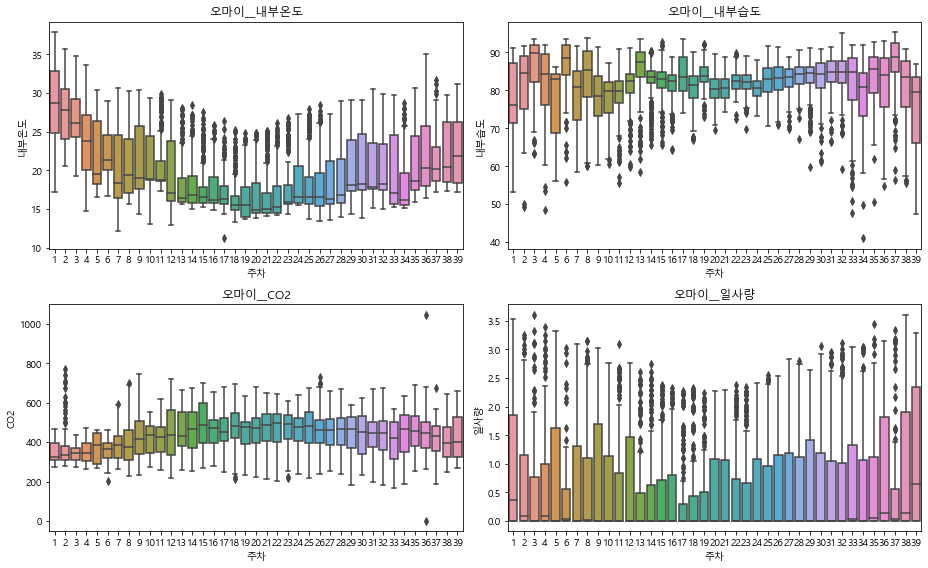

---------------------------------------------------------------------------------------------
---------------------------------------------------------------------------------------------


In [37]:
# 이상치 파악하기

box_to_find_outlier(env_data,name,cols)
env_data=env_data.reset_index(drop=True)


이상치가 많다는 것을 알 수 있다.

# 생육 이상치 제거

In [38]:
# 평균으로 집계할 변수와, 합으로 집계할 변수 설정하기
base_col=['Date','주차']
sang_remove_target=['생장길이']

In [39]:
i=0
for col in sang_remove_target:
    df=sang_data[[col,'주차']]

    # 이상치 제거
    my_df = remove_outlier(df,col)


    if i==0:
        sang_result = my_df
        i+=1
        continue

    sang_result = pd.merge(sang_result,my_df,how='inner',on='주차')

In [40]:
sang_result=sang_data.iloc[sang_result.index,:]

# 환경 이상치 제거 후 집계

In [41]:
# 평균으로 집계할 변수와, 합으로 집계할 변수 설정하기
base_col=['date','Date','주차']
avg_list=['내부온도','내부습도','CO2']
sum_list=['일사량']
cols=avg_list+sum_list
aggfunc=['mean']*len(avg_list)+['sum']*len(sum_list)

In [42]:
# evn데이터 이상치 제거

i=0
for col,agg in zip(cols,aggfunc):
    df=env_data[[col,'주차']]

    # 이상치 제거, 피봇
    my_pivot = removed_outlier_pivot(df,col,agg)


    if i==0:
        env_pivot = my_pivot
        i+=1
        continue

    env_pivot = pd.merge(env_pivot,my_pivot,how='inner',on='주차')


# 집계 데이터 주차별로 시각화

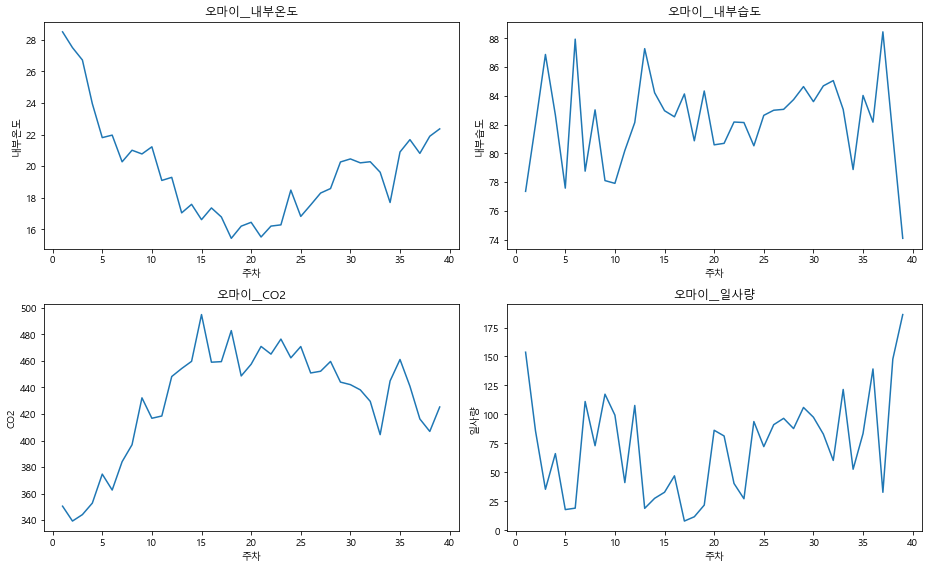

In [43]:
plt.figure(figsize=[13,8])
plt.subplots_adjust(left = 0, bottom = 0, right = 1, top = 1, hspace = 1, wspace = 0.5)
cnt_cols = 2
cnt_rows = 2

for k,col in enumerate(cols):
    plt.subplot(cnt_rows, cnt_cols, k+1)
    sns.lineplot(data=env_pivot,x='주차',y=col)
    plt.title(name[:-3:]+'_'+col)
    plt.tight_layout()
plt.show()

    
    

# 분석

# 온도에 따른 생장길이

In [44]:
# 생육과 환경조인
sang_env = pd.merge(sang_result,env_pivot,on='주차',how='inner')


<Figure size 1080x720 with 0 Axes>

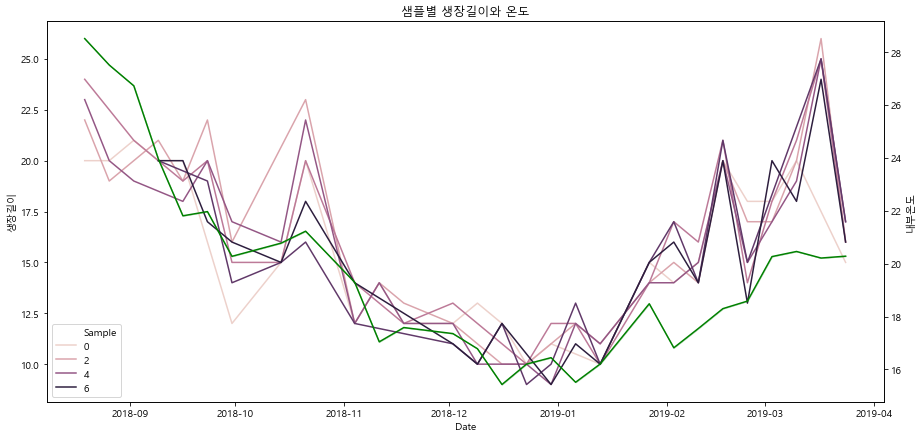

In [45]:
plt.figure(figsize=(15,10))
이중축그래프(data=sang_env,x='내부온도',y='생장길이',
      title='샘플별 생장길이와 온도')

<Figure size 1080x720 with 0 Axes>

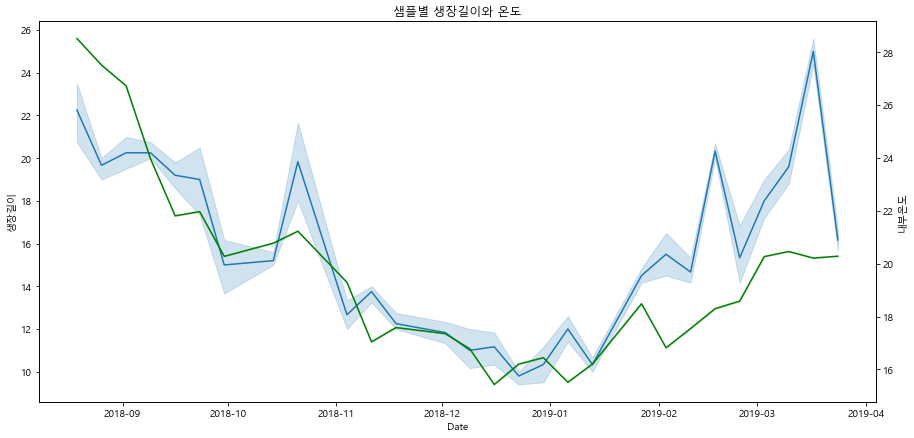

In [46]:
plt.figure(figsize=(15,10))
이중축그래프(data=sang_env,x='내부온도',y='생장길이', hue=None,
      title='샘플별 생장길이와 온도')

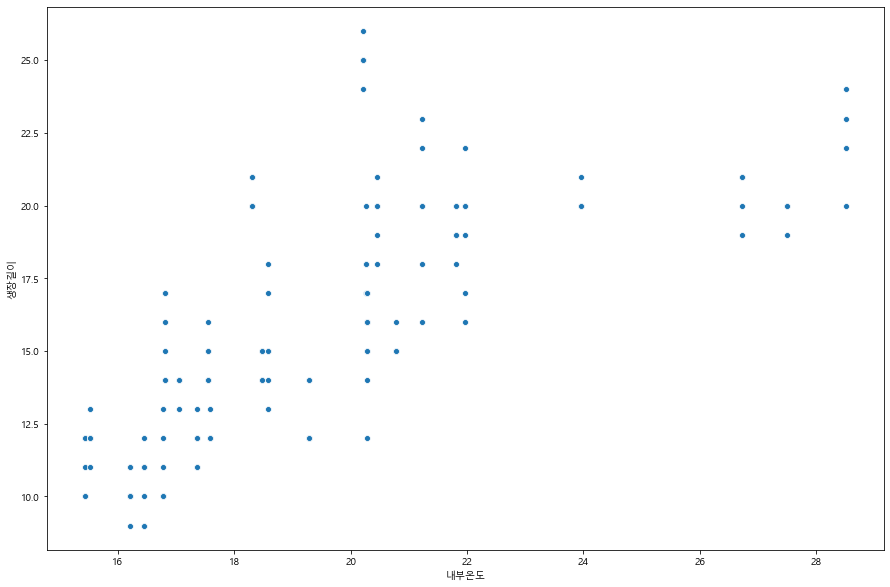

In [47]:
plt.figure(figsize=(15,10))
sns.scatterplot(data=sang_env, x= "내부온도", y = "생장길이")

In [48]:
sang_env[['생장길이','내부온도','내부습도','CO2','일사량']].corr()

,생장길이,내부온도,내부습도,CO2,일사량
생장길이,1.000000,0.721342,0.029234,-0.597060,0.348269
내부온도,0.721342,1.000000,-0.088082,-0.902587,0.327960
내부습도,0.029234,-0.088082,1.000000,0.054166,-0.467231
CO2,-0.597060,-0.902587,0.054166,1.000000,-0.096247
일사량,0.348269,0.327960,-0.467231,-0.096247,1.000000


종속변수와 내부온도의 상관계수가 높고 co2도 선형성이 조금 있고
나머지는 선형성이 있다고는 말하기는 상관관계가 낮다

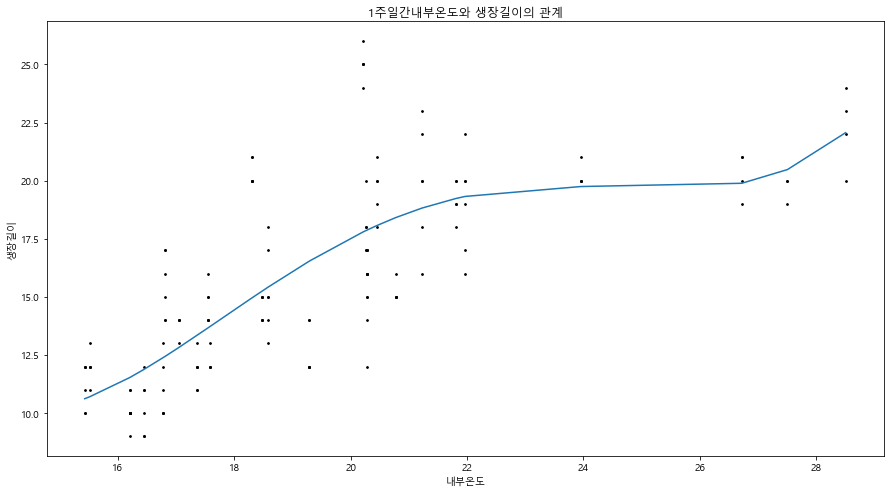

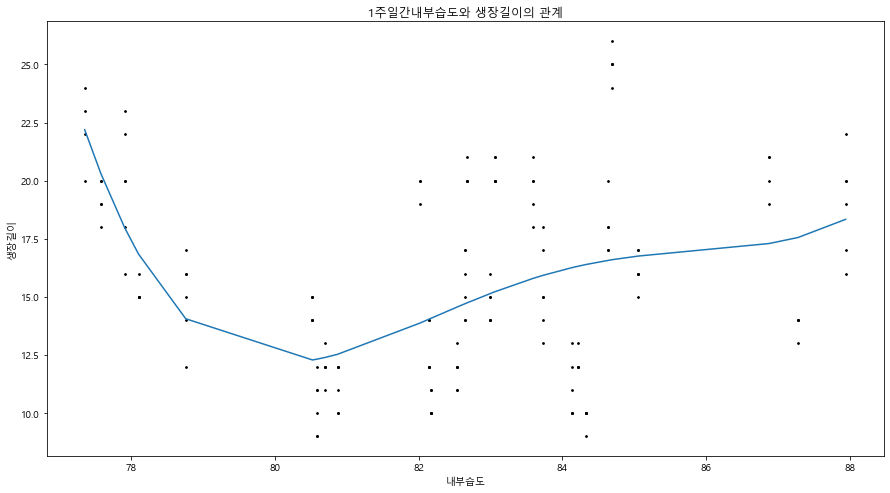

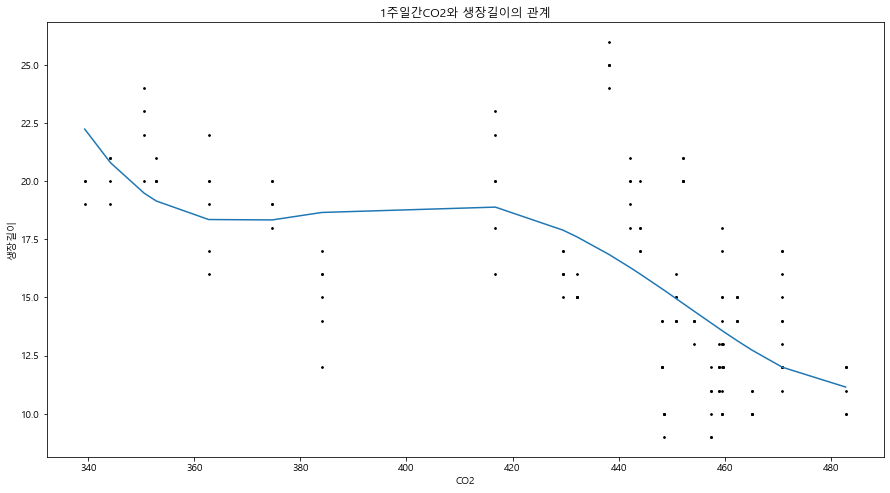

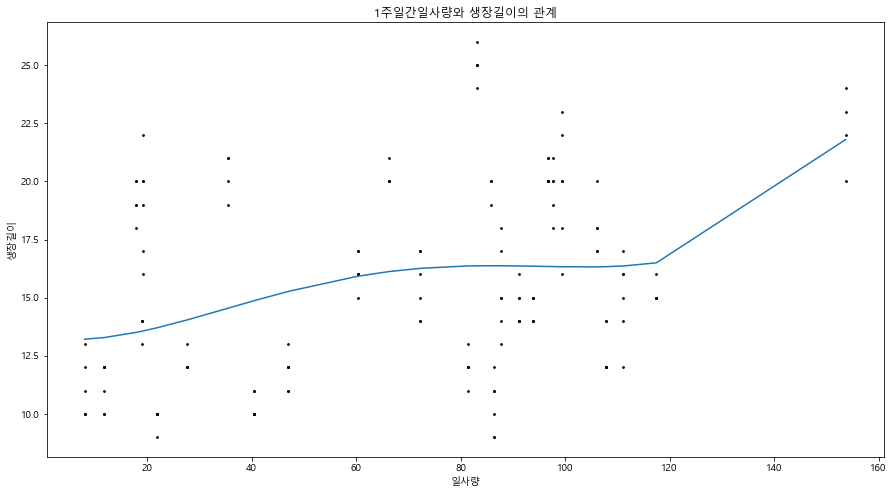

In [49]:
for i in ['내부온도','내부습도','CO2','일사량']:
    다항회귀함수(data = sang_env,x=i,y='생장길이',degree=4,
          title='1주일간'+i+'와 생장길이의 관계',xlab=i,ylab='생장길이')

In [50]:
df = sang_env.pivot_table(index="주차",
                         values=['생장길이','내부온도','내부습도','CO2','일사량'],
                         aggfunc='mean').reset_index(drop=True)

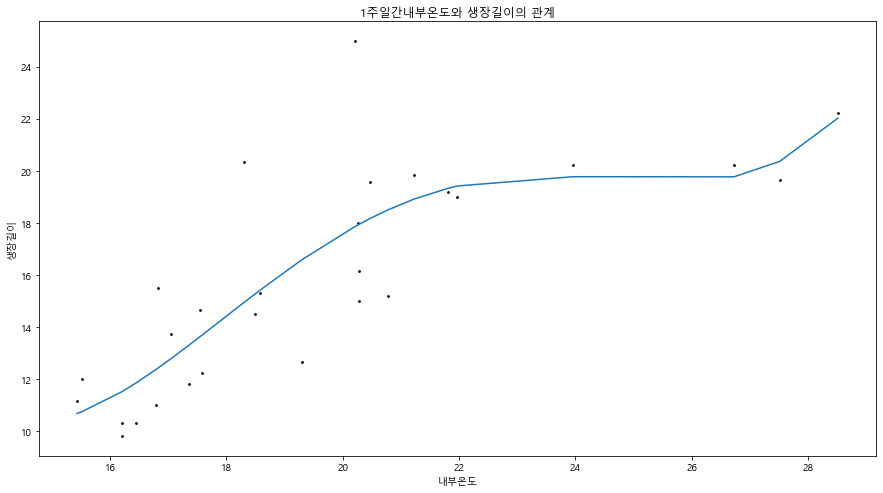

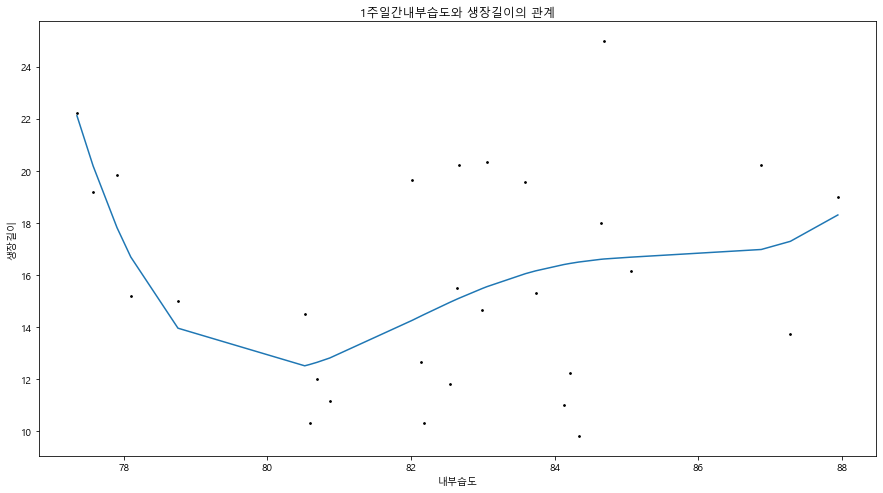

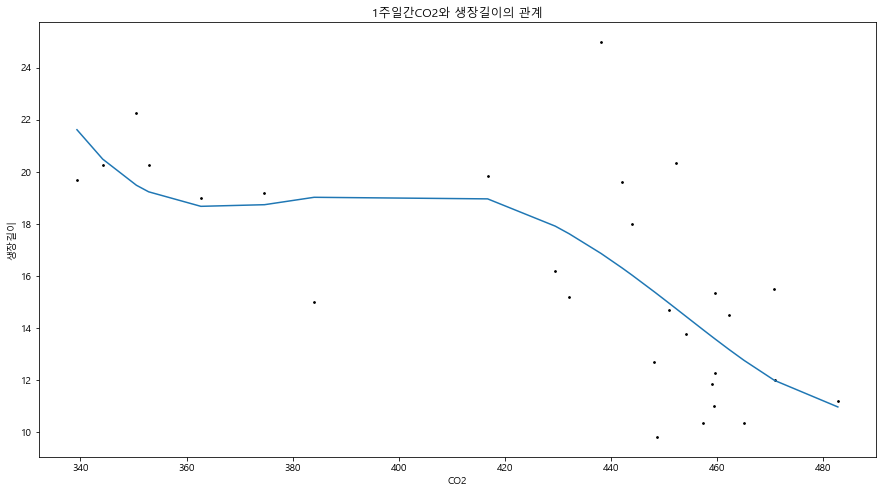

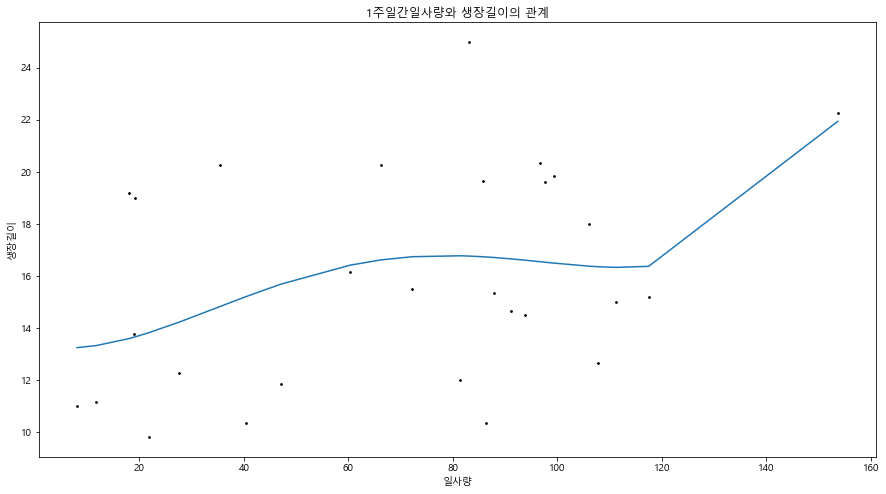

In [51]:
for i in ['내부온도','내부습도','CO2','일사량']:
    다항회귀함수(data = df,x=i,y='생장길이',degree=4,
      title='1주일간'+i+'와 생장길이의 관계',xlab=i,ylab='생장길이')

# 양액

공급sum < 배액sum 이라 데이터가 이상하다. 맞죠..? </br>
양액을 고려하지 않고 모델을 만든다.

# 지연변수 생성 (주단위)
여러 실험을 통해 3주 까지 보는게 더 낫다

In [52]:
lag_result=env_pivot
for i in range(3):
    raw_col=env_pivot.columns[1:]
    later_df=env_pivot.iloc[:,1:].shift(periods=i+1)
    later_col=['_'+str(i+1)+'주전_'+j for j in list(raw_col)]
    later_df.columns=later_col

    lag_result=pd.concat([lag_result,later_df],axis=1)


In [53]:
env_pivot.head(5)

,주차,내부온도,내부습도,CO2,일사량
0,1,28.511180,77.350311,350.559006,153.70
1,2,27.511180,82.016981,339.349315,85.77
2,3,26.726087,86.875188,344.202899,35.46
3,4,23.959006,82.666456,352.863354,66.23
4,5,21.810000,77.575000,374.700000,17.93


In [54]:
lag_result.head(5)

,주차,내부온도,내부습도,CO2,일사량,_1주전_내부온도,_1주전_내부습도,_1주전_CO2,_1주전_일사량,_2주전_내부온도,_2주전_내부습도,_2주전_CO2,_2주전_일사량,_3주전_내부온도,_3주전_내부습도,_3주전_CO2,_3주전_일사량
0,1,28.511180,77.350311,350.559006,153.70,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2,27.511180,82.016981,339.349315,85.77,28.511180,77.350311,350.559006,153.70,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,3,26.726087,86.875188,344.202899,35.46,27.511180,82.016981,339.349315,85.77,28.511180,77.350311,350.559006,153.70,NaN,NaN,NaN,NaN
3,4,23.959006,82.666456,352.863354,66.23,26.726087,86.875188,344.202899,35.46,27.511180,82.016981,339.349315,85.77,28.51118,77.350311,350.559006,153.70
4,5,21.810000,77.575000,374.700000,17.93,23.959006,82.666456,352.863354,66.23,26.726087,86.875188,344.202899,35.46,27.51118,82.016981,339.349315,85.77


In [55]:
merge_dataset = pd.merge(sang_result,lag_result,how='inner',on='주차')


# 생장길이 예측

# xgboost

In [56]:
from sklearn.datasets import load_boston
import xgboost
from sklearn.model_selection import train_test_split
from sklearn.metrics import explained_variance_score
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import mean_squared_error
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import Lasso
from sklearn.ensemble import RandomForestRegressor

from sklearn.model_selection import KFold

In [79]:
def xgb(df,Y,parameters,col):

    test_size=0.25
    
    xgb_model = xgboost.XGBRegressor(n_estimators=100, gamma=0,
                               colsample_bytree=1, max_depth=7)

    
    xgb_regressor = GridSearchCV(xgb_model,parameters,scoring='neg_mean_squared_error',cv=10)

    x_train=df.iloc[:,col]
    y_train=df[Y]
    
    
    
    
    xgb_regressor.fit(x_train,y_train)
    print(xgb_regressor.best_params_)
    
    eta=xgb_regressor.best_params_['eta']
    learning_rate=xgb_regressor.best_params_['learning_rate']
    subsample = xgb_regressor.best_params_['subsample']
    
    # Kfold
    X_train, X_test, y_train, y_test = train_test_split(x_train, y_train, test_size=test_size)
    xgb_model = xgboost.XGBRegressor(n_estimators=100,  gamma=0,colsample_bytree=1, max_depth=7,
                                     learning_rate=learning_rate,
                                     subsample=subsample,
                                     eta=eta
                           )

    print(len(X_train), len(X_test))
    
    xgb_model.fit(X_train,y_train)
    predictions = xgb_model.predict(X_test)
    RMSE = mean_squared_error(y_test, predictions)**0.5
    print(RMSE)
    
    
    xgboost.plot_importance(xgb_model)
    
    
    plt.figure(figsize=[24,12])
    sns.lineplot(x=range(len(predictions)),y=predictions,label="pred")
    sns.lineplot(x=range(len(y_test)),y=y_test,label="Test")
    plt.show()
   
    plt.figure(figsize=[24,12])
    sns.lineplot(x=range(len(y_test)),y=y_test-predictions,label="Test")
    plt.title("차이")
    plt.show()
    print("--------------------------------------------------------------------------------------------")
    print("--------------------------------------------------------------------------------------------")
    print("--------------------------------------------------------------------------------------------")
    
    result_df = pd.DataFrame({'y_test':y_test,
                             'pred':predictions,
                             '차이':abs(y_test-predictions)})
    result_df=result_df.sort_values('차이',ascending=False).head(6)
    
    
    return result_df

In [74]:
def xgb(df,Y,parameters,col):

    test_size=0.25
    
    xgb_model = xgboost.XGBRegressor(n_estimators=100, gamma=0,
                               colsample_bytree=1, max_depth=7)

    
    xgb_regressor = GridSearchCV(xgb_model,parameters,scoring='neg_mean_squared_error',cv=10)

    x_train=df.iloc[:,col]
    y_train=df[Y]
    
    
    
    
    xgb_regressor.fit(x_train,y_train)
    print(xgb_regressor.best_params_)
    
    eta=xgb_regressor.best_params_['eta']
    learning_rate=xgb_regressor.best_params_['learning_rate']
    subsample = xgb_regressor.best_params_['subsample']
    
    # Kfold
    X_train, X_test, y_train, y_test = train_test_split(x_train, y_train, test_size=test_size)
    xgb_model = xgboost.XGBRegressor(n_estimators=100,  gamma=0,colsample_bytree=1, max_depth=7,
                                     learning_rate=learning_rate,
                                     subsample=subsample,
                                     eta=eta
                           )

    print(len(X_train), len(X_test))
    
    xgb_model.fit(X_train,y_train)
    predictions = xgb_model.predict(X_test)
    RMSE = mean_squared_error(y_test, predictions)**0.5
    print(RMSE)
    
    
    xgboost.plot_importance(xgb_model)
    
    
    plt.figure(figsize=[24,12])
    sns.lineplot(x=range(len(predictions)),y=predictions,label="pred")
    sns.lineplot(x=range(len(y_test)),y=y_test,label="Test")
    plt.show()
   
    plt.figure(figsize=[24,12])
    sns.lineplot(x=range(len(y_test)),y=y_test-predictions,label="Test")
    plt.title("차이")
    plt.show()
    print("--------------------------------------------------------------------------------------------")
    print("--------------------------------------------------------------------------------------------")
    print("--------------------------------------------------------------------------------------------")
    
    result_df = pd.DataFrame({'y_test':y_test,
                             'pred':predictions,
                             '차이':abs(y_test-predictions)})
    result_df=result_df.sort_values('차이',ascending=False).head(6)
    
    
    return result_df

## 튜닝1

In [59]:
model_dataset=merge_dataset[['생장길이']+list(merge_dataset.columns[list(range(7,len(merge_dataset.columns)))])].dropna()

In [73]:
model_dataset.head(3)

,생장길이,주차,내부온도,내부습도,CO2,일사량,_1주전_내부온도,_1주전_내부습도,_1주전_CO2,_1주전_일사량,_2주전_내부온도,_2주전_내부습도,_2주전_CO2,_2주전_일사량,_3주전_내부온도,_3주전_내부습도,_3주전_CO2,_3주전_일사량
11,20.0,4,23.959006,82.666456,352.863354,66.23,26.726087,86.875188,344.202899,35.46,27.51118,82.016981,339.349315,85.77,28.51118,77.350311,350.559006,153.7
12,21.0,4,23.959006,82.666456,352.863354,66.23,26.726087,86.875188,344.202899,35.46,27.51118,82.016981,339.349315,85.77,28.51118,77.350311,350.559006,153.7
13,20.0,4,23.959006,82.666456,352.863354,66.23,26.726087,86.875188,344.202899,35.46,27.51118,82.016981,339.349315,85.77,28.51118,77.350311,350.559006,153.7


{'eta': 0.001, 'learning_rate': 0.13, 'subsample': 0.85}
102 35
1.2275338833181113


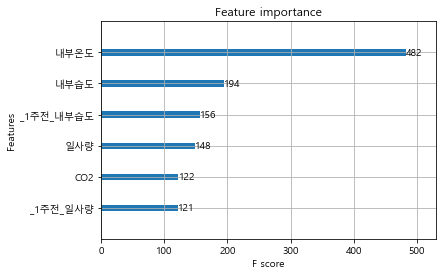

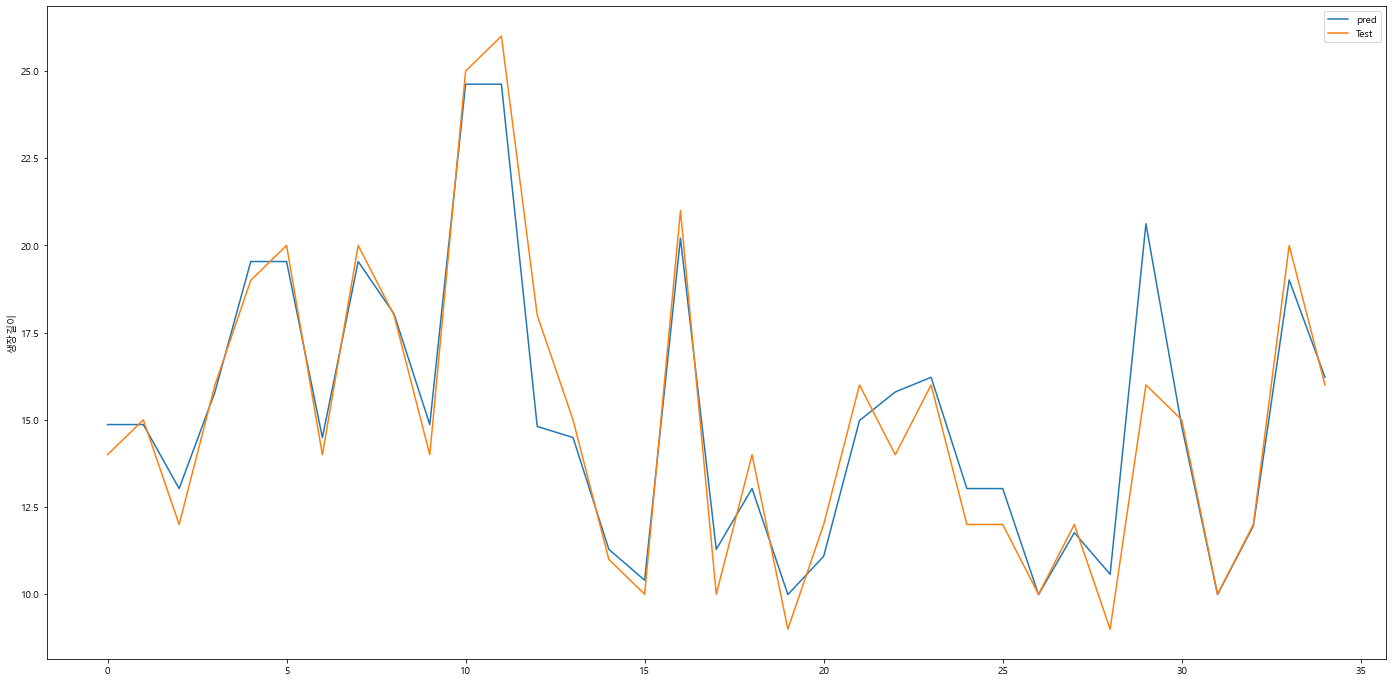

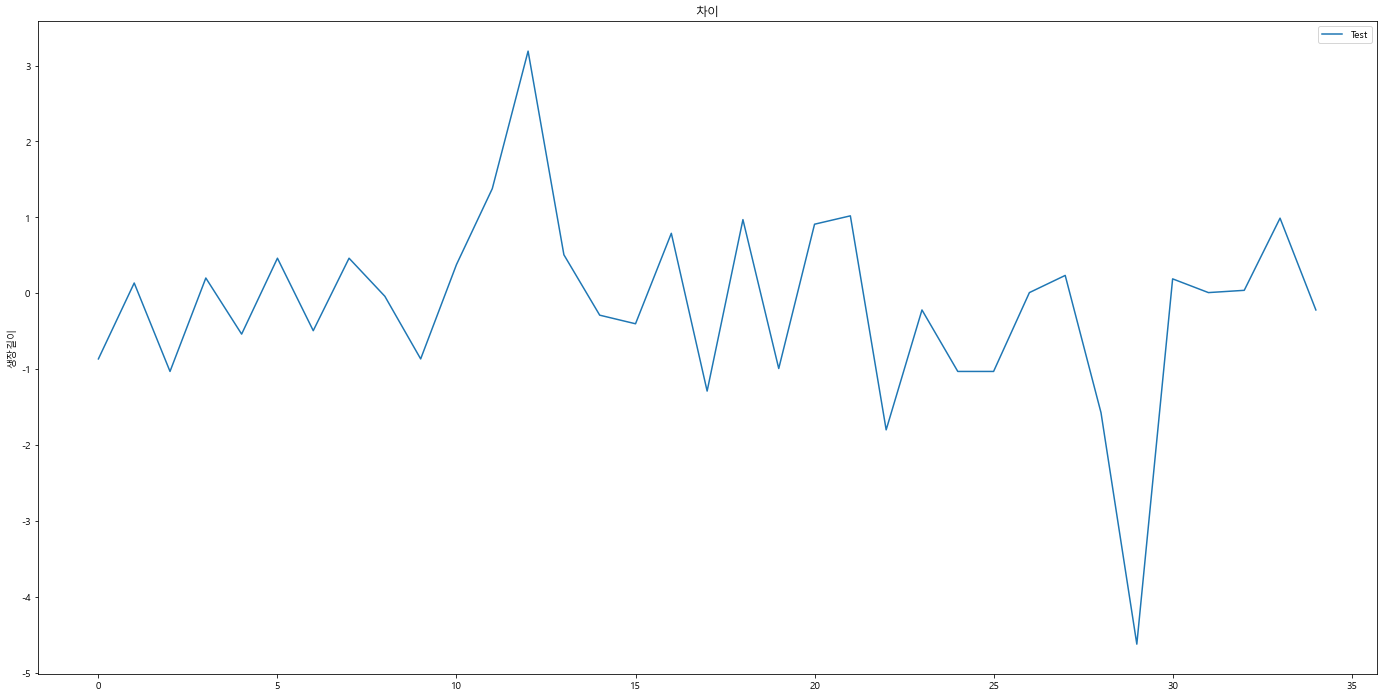

--------------------------------------------------------------------------------------------
--------------------------------------------------------------------------------------------
--------------------------------------------------------------------------------------------


,Date,WeekNum,Sample,초장,생장길이,화방높이,줄기굵기,주차,내부온도,내부습도,CO2,일사량,_1주전_내부온도,_1주전_내부습도,_1주전_CO2,_1주전_일사량,_2주전_내부온도,_2주전_내부습도,_2주전_CO2,_2주전_일사량,_3주전_내부온도,_3주전_내부습도,_3주전_CO2,_3주전_일사량
41,2018-10-21,43,5,NaN,16.0,30.0,11.88,10,21.227742,77.907843,416.761290,99.40,20.775776,78.099379,432.142857,117.48,21.011180,83.020126,396.825000,73.03,20.277640,78.756522,384.056250,111.18
121,2019-02-24,9,1,NaN,18.0,33.0,17.49,28,18.584472,83.734810,459.552795,87.82,18.299379,83.057692,452.173913,96.65,17.548000,82.994969,450.873418,91.18,16.818841,82.639130,470.782609,72.25
103,2019-02-03,6,1,NaN,14.0,33.0,18.79,25,16.818841,82.639130,470.782609,72.25,18.484472,80.520497,462.267081,93.89,16.283459,82.139103,476.396226,27.28,16.205479,82.175000,465.074534,40.45
85,2018-12-30,53,6,NaN,9.0,13.0,10.80,20,16.445455,80.588125,457.440994,86.36,16.201935,84.333775,448.633540,21.81,15.430534,80.869231,482.773585,11.74,16.783673,84.127950,459.403727,8.04
137,2019-03-17,12,2,NaN,26.0,44.0,14.74,31,20.212422,84.689744,438.136646,83.05,20.460870,83.593506,442.093168,97.62,20.267702,84.640288,443.993789,106.04,18.584472,83.734810,459.552795,87.82
67,2018-12-09,50,5,NaN,10.0,17.0,12.74,17,16.783673,84.127950,459.403727,8.04,17.355844,82.537333,458.987578,47.05,16.614394,82.962759,494.850932,32.89,17.584247,84.212800,459.639752,27.64


In [82]:
parameters = {'eta':[0.001,0.005,0.01],
              'learning_rate':[0.13,0.15,0.17],
              'subsample':[0.85,0.86,0.9]}
col=[2,3,4,5,7,9]


result = xgb(model_dataset,'생장길이',parameters=parameters,col=col)
merge_dataset.iloc[result.index,:]

{'eta': 0.001, 'learning_rate': 0.13, 'subsample': 0.85}
102 35
1.4774691354159535


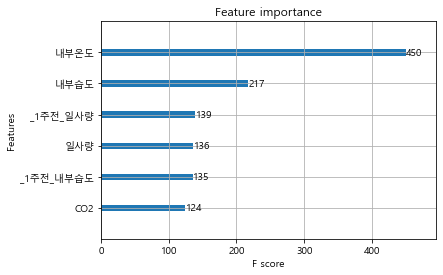

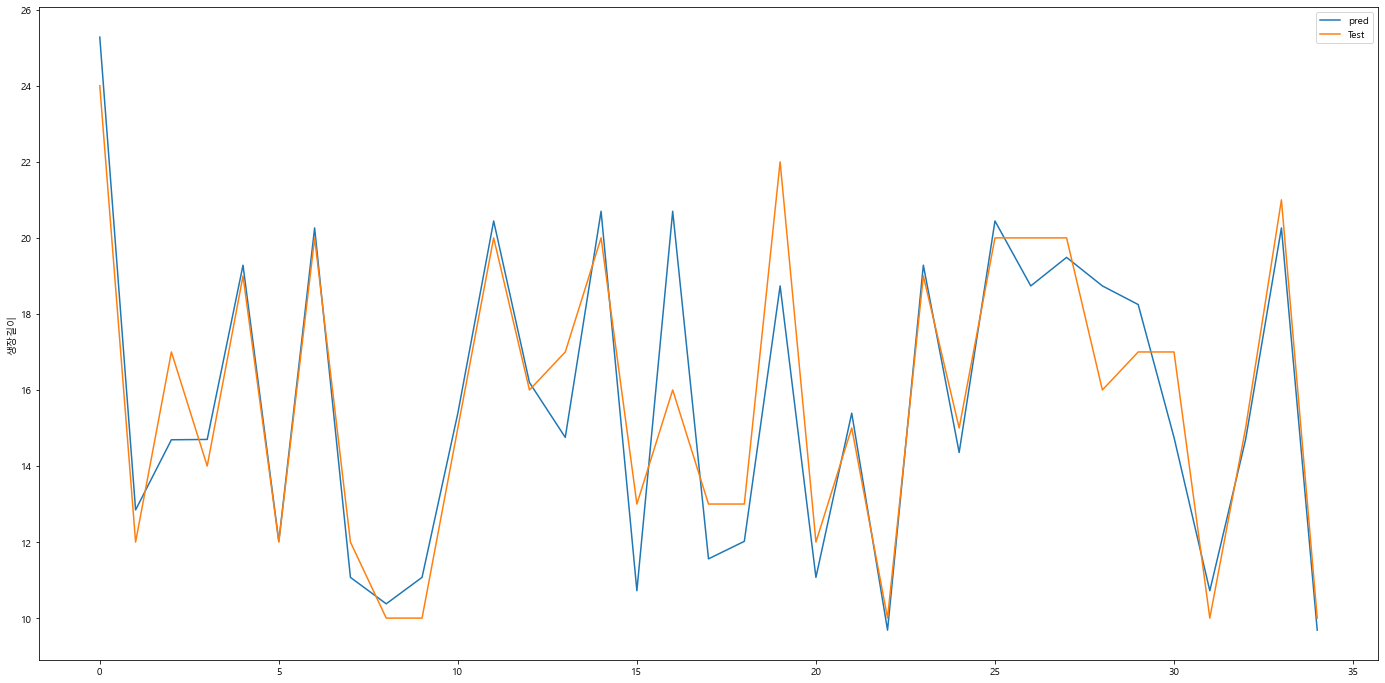

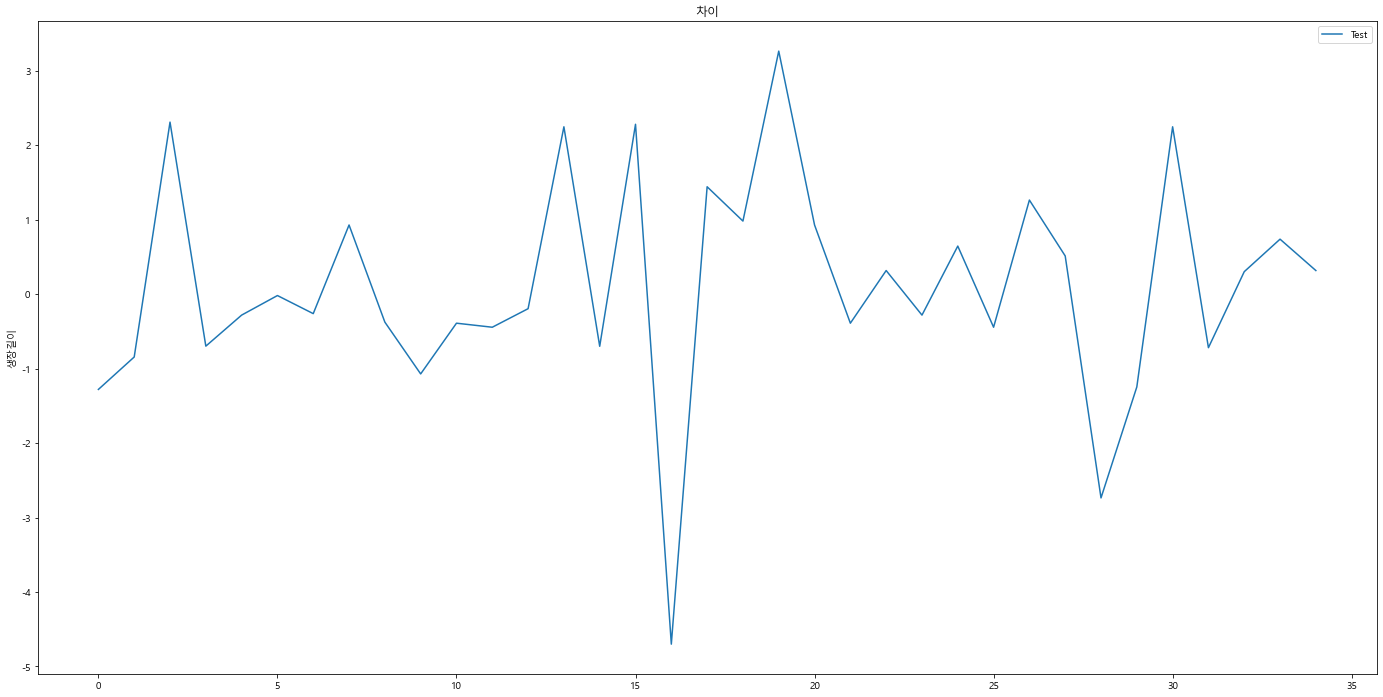

--------------------------------------------------------------------------------------------
--------------------------------------------------------------------------------------------
--------------------------------------------------------------------------------------------


,Date,WeekNum,Sample,초장,생장길이,화방높이,줄기굵기,주차,내부온도,내부습도,CO2,일사량,_1주전_내부온도,_1주전_내부습도,_1주전_CO2,_1주전_일사량,_2주전_내부온도,_2주전_내부습도,_2주전_CO2,_2주전_일사량,_3주전_내부온도,_3주전_내부습도,_3주전_CO2,_3주전_일사량
41,2018-10-21,43,5,NaN,16.0,30.0,11.88,10,21.227742,77.907843,416.761290,99.40,20.775776,78.099379,432.142857,117.48,21.011180,83.020126,396.825000,73.03,20.277640,78.756522,384.056250,111.18
21,2018-09-23,39,2,NaN,22.0,24.0,15.12,6,21.968817,87.941176,362.706522,19.17,21.810000,77.575000,374.700000,17.93,23.959006,82.666456,352.863354,66.23,26.726087,86.875188,344.202899,35.46
20,2018-09-23,39,1,NaN,16.0,17.0,15.75,6,21.968817,87.941176,362.706522,19.17,21.810000,77.575000,374.700000,17.93,23.959006,82.666456,352.863354,66.23,26.726087,86.875188,344.202899,35.46
29,2018-09-30,40,4,NaN,17.0,23.0,16.25,7,20.277640,78.756522,384.056250,111.18,21.968817,87.941176,362.706522,19.17,21.810000,77.575000,374.700000,17.93,23.959006,82.666456,352.863354,66.23
63,2018-12-09,50,1,NaN,13.0,17.0,13.66,17,16.783673,84.127950,459.403727,8.04,17.355844,82.537333,458.987578,47.05,16.614394,82.962759,494.850932,32.89,17.584247,84.212800,459.639752,27.64
105,2019-02-03,6,3,NaN,17.0,34.0,16.87,25,16.818841,82.639130,470.782609,72.25,18.484472,80.520497,462.267081,93.89,16.283459,82.139103,476.396226,27.28,16.205479,82.175000,465.074534,40.45


In [83]:
parameters = {'eta':[0.001,0.005,0.01],
              'learning_rate':[0.13,0.15,0.17],
              'subsample':[0.85,0.86,0.9]}
col=[2,3,4,5,7,9]


result = xgb(model_dataset,'생장길이',parameters=parameters,col=col)
merge_dataset.iloc[result.index,:]

{'eta': 0.001, 'learning_rate': 0.13, 'subsample': 0.85}
102 35
1.3228031254578536


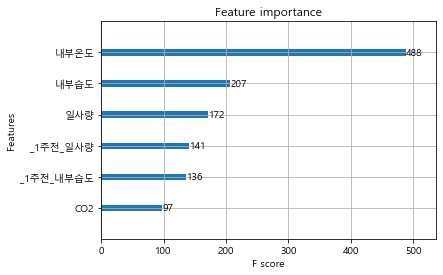

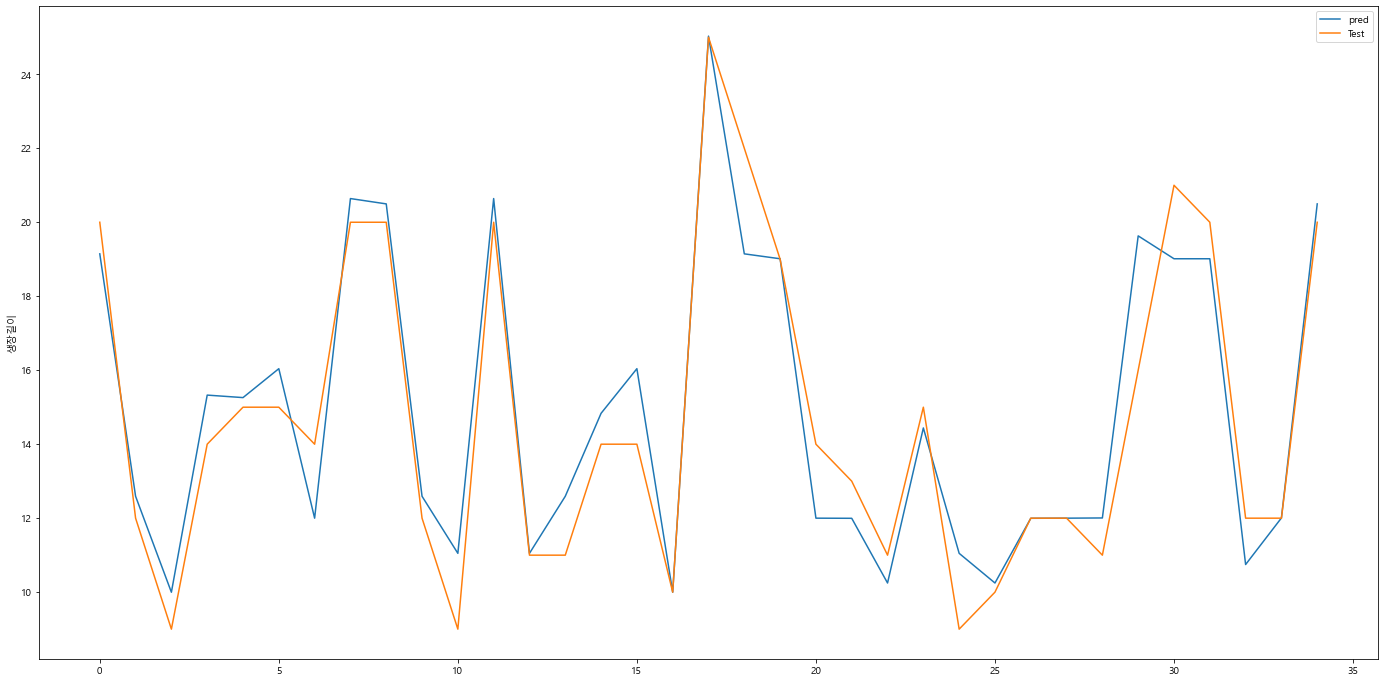

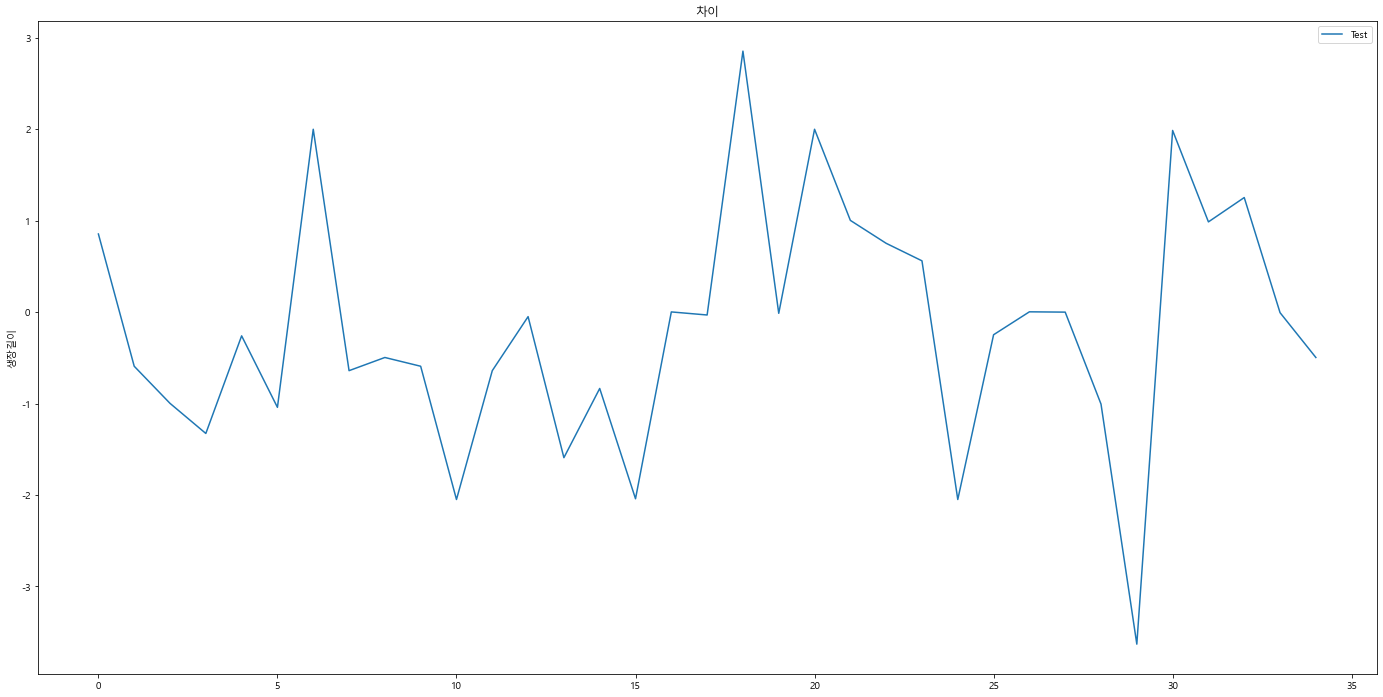

--------------------------------------------------------------------------------------------
--------------------------------------------------------------------------------------------
--------------------------------------------------------------------------------------------


,Date,WeekNum,Sample,초장,생장길이,화방높이,줄기굵기,주차,내부온도,내부습도,CO2,일사량,_1주전_내부온도,_1주전_내부습도,_1주전_CO2,_1주전_일사량,_2주전_내부온도,_2주전_내부습도,_2주전_CO2,_2주전_일사량,_3주전_내부온도,_3주전_내부습도,_3주전_CO2,_3주전_일사량
20,2018-09-23,39,1,NaN,16.0,17.0,15.75,6,21.968817,87.941176,362.706522,19.17,21.810000,77.575000,374.700000,17.93,23.959006,82.666456,352.863354,66.23,26.726087,86.875188,344.202899,35.46
40,2018-10-21,43,4,NaN,22.0,22.0,13.77,10,21.227742,77.907843,416.761290,99.40,20.775776,78.099379,432.142857,117.48,21.011180,83.020126,396.825000,73.03,20.277640,78.756522,384.056250,111.18
85,2018-12-30,53,6,NaN,9.0,13.0,10.80,20,16.445455,80.588125,457.440994,86.36,16.201935,84.333775,448.633540,21.81,15.430534,80.869231,482.773585,11.74,16.783673,84.127950,459.403727,8.04
83,2018-12-30,53,4,NaN,9.0,25.0,13.30,20,16.445455,80.588125,457.440994,86.36,16.201935,84.333775,448.633540,21.81,15.430534,80.869231,482.773585,11.74,16.783673,84.127950,459.403727,8.04
106,2019-02-03,6,4,NaN,14.0,23.0,13.26,25,16.818841,82.639130,470.782609,72.25,18.484472,80.520497,462.267081,93.89,16.283459,82.139103,476.396226,27.28,16.205479,82.175000,465.074534,40.45
48,2018-11-04,45,6,NaN,14.0,25.0,14.21,12,19.293750,82.141667,448.193750,107.77,19.097692,80.191892,418.468750,41.23,21.227742,77.907843,416.761290,99.40,20.775776,78.099379,432.142857,117.48


In [84]:
parameters = {'eta':[0.001,0.005,0.01],
              'learning_rate':[0.13,0.15,0.17],
              'subsample':[0.85,0.86,0.9]}
col=[2,3,4,5,7,9]


result = xgb(model_dataset,'생장길이',parameters=parameters,col=col)
merge_dataset.iloc[result.index,:]

## 튜닝2

{'eta': 0.001, 'learning_rate': 0.1, 'subsample': 0.85}
102 35
1.3905381218903448


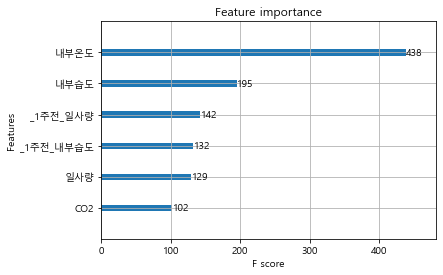

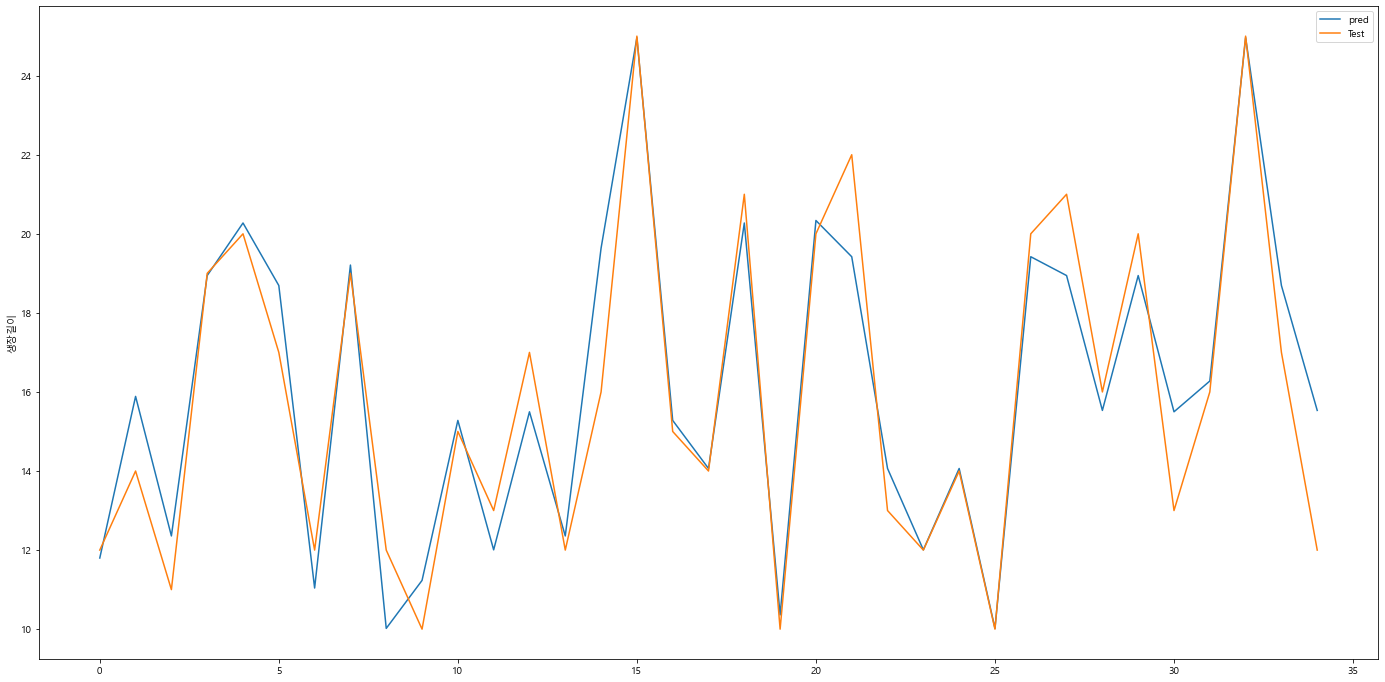

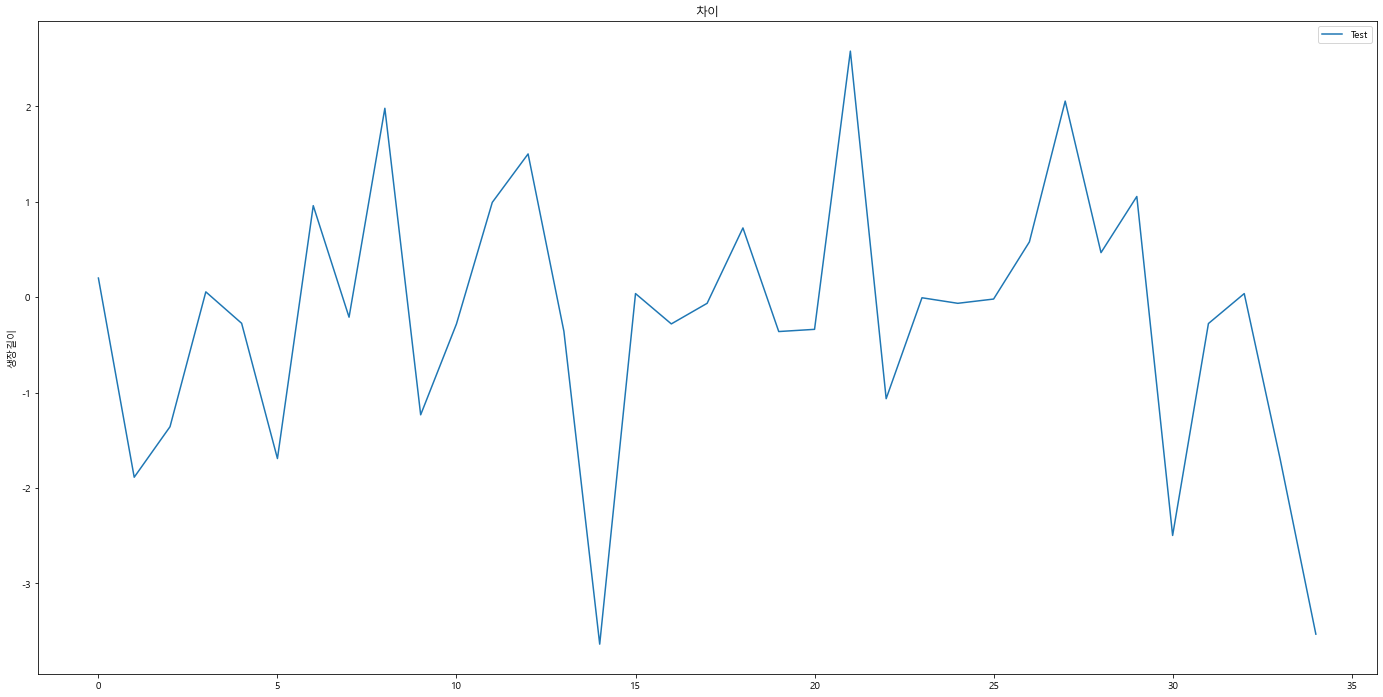

--------------------------------------------------------------------------------------------
--------------------------------------------------------------------------------------------
--------------------------------------------------------------------------------------------


,Date,WeekNum,Sample,초장,생장길이,화방높이,줄기굵기,주차,내부온도,내부습도,CO2,일사량,_1주전_내부온도,_1주전_내부습도,_1주전_CO2,_1주전_일사량,_2주전_내부온도,_2주전_내부습도,_2주전_CO2,_2주전_일사량,_3주전_내부온도,_3주전_내부습도,_3주전_CO2,_3주전_일사량
20,2018-09-23,39,1,NaN,16.0,17.0,15.75,6,21.968817,87.941176,362.706522,19.17,21.810000,77.575000,374.700000,17.93,23.959006,82.666456,352.863354,66.23,26.726087,86.875188,344.202899,35.46
26,2018-09-30,40,1,NaN,12.0,6.0,9.50,7,20.277640,78.756522,384.056250,111.18,21.968817,87.941176,362.706522,19.17,21.810000,77.575000,374.700000,17.93,23.959006,82.666456,352.863354,66.23
40,2018-10-21,43,4,NaN,22.0,22.0,13.77,10,21.227742,77.907843,416.761290,99.40,20.775776,78.099379,432.142857,117.48,21.011180,83.020126,396.825000,73.03,20.277640,78.756522,384.056250,111.18
126,2019-02-24,9,6,NaN,13.0,29.0,15.93,28,18.584472,83.734810,459.552795,87.82,18.299379,83.057692,452.173913,96.65,17.548000,82.994969,450.873418,91.18,16.818841,82.639130,470.782609,72.25
134,2019-03-10,11,3,NaN,21.0,22.0,12.46,30,20.460870,83.593506,442.093168,97.62,20.267702,84.640288,443.993789,106.04,18.584472,83.734810,459.552795,87.82,18.299379,83.057692,452.173913,96.65
82,2018-12-30,53,3,NaN,12.0,17.0,12.49,20,16.445455,80.588125,457.440994,86.36,16.201935,84.333775,448.633540,21.81,15.430534,80.869231,482.773585,11.74,16.783673,84.127950,459.403727,8.04


In [86]:
parameters = {'eta':[0.001,0.005,0.01],
              'learning_rate':[0.1,0.13],
              'subsample':[0.84,0.85,0.87,0.9]}
col=[2,3,4,5,7,9]
result = xgb(model_dataset,'생장길이',parameters=parameters,col=col)
merge_dataset.iloc[result.index,:]

In [ ]:
parameters = {'eta':[0.001,0.005,0.01],
              'learning_rate':[0.1,0.13],
              'subsample':[0.84,0.85,0.87,0.9]}
col=[2,3,4,5,7,9]
result = xgb(model_dataset,'생장길이',parameters=parameters,col=col)
merge_dataset.iloc[result.index,:]

{'eta': 0.001, 'learning_rate': 0.1, 'subsample': 0.85}
102 35
1.1619706037366186


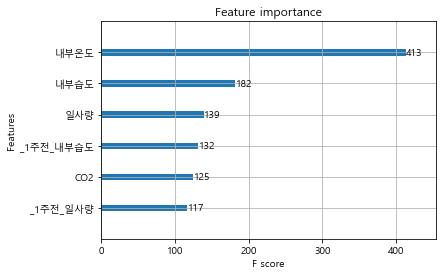

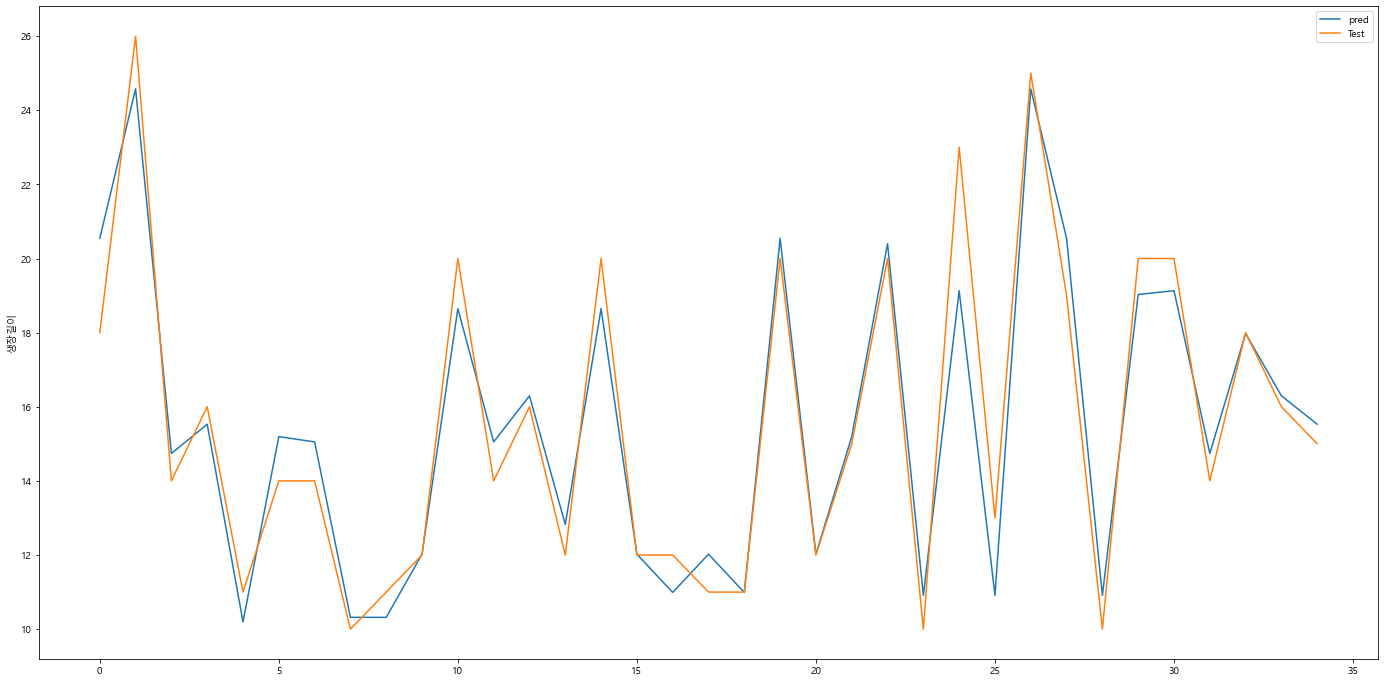

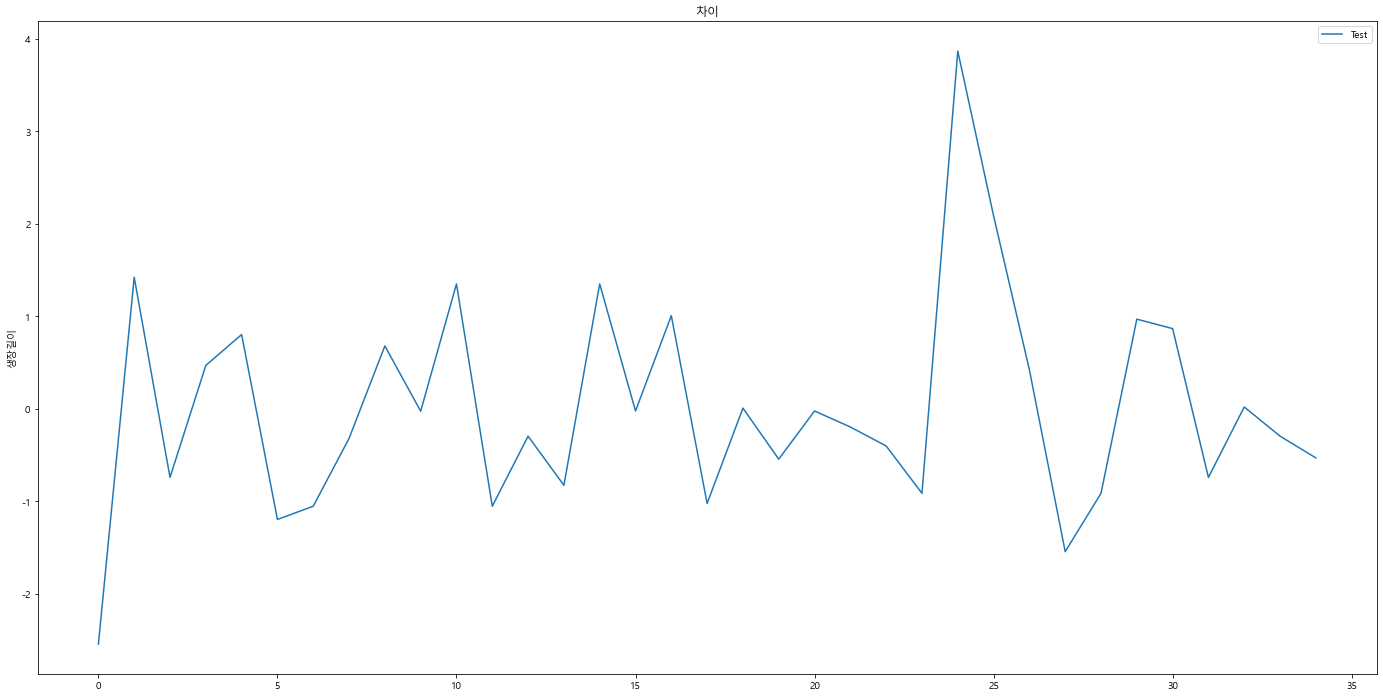

--------------------------------------------------------------------------------------------
--------------------------------------------------------------------------------------------
--------------------------------------------------------------------------------------------


,Date,WeekNum,Sample,초장,생장길이,화방높이,줄기굵기,주차,내부온도,내부습도,CO2,일사량,_1주전_내부온도,_1주전_내부습도,_1주전_CO2,_1주전_일사량,_2주전_내부온도,_2주전_내부습도,_2주전_CO2,_2주전_일사량,_3주전_내부온도,_3주전_내부습도,_3주전_CO2,_3주전_일사량
38,2018-10-21,43,2,NaN,23.0,20.0,14.55,10,21.227742,77.907843,416.761290,99.40,20.775776,78.099379,432.142857,117.48,21.011180,83.020126,396.825000,73.03,20.277640,78.756522,384.056250,111.18
136,2019-03-10,11,6,NaN,18.0,19.0,12.74,30,20.460870,83.593506,442.093168,97.62,20.267702,84.640288,443.993789,106.04,18.584472,83.734810,459.552795,87.82,18.299379,83.057692,452.173913,96.65
63,2018-12-09,50,1,NaN,13.0,17.0,13.66,17,16.783673,84.127950,459.403727,8.04,17.355844,82.537333,458.987578,47.05,16.614394,82.962759,494.850932,32.89,17.584247,84.212800,459.639752,27.64
135,2019-03-10,11,4,NaN,19.0,35.0,12.22,30,20.460870,83.593506,442.093168,97.62,20.267702,84.640288,443.993789,106.04,18.584472,83.734810,459.552795,87.82,18.299379,83.057692,452.173913,96.65
137,2019-03-17,12,2,NaN,26.0,44.0,14.74,31,20.212422,84.689744,438.136646,83.05,20.460870,83.593506,442.093168,97.62,20.267702,84.640288,443.993789,106.04,18.584472,83.734810,459.552795,87.82
23,2018-09-23,39,4,NaN,20.0,10.0,14.19,6,21.968817,87.941176,362.706522,19.17,21.810000,77.575000,374.700000,17.93,23.959006,82.666456,352.863354,66.23,26.726087,86.875188,344.202899,35.46


In [87]:
parameters = {'eta':[0.001,0.005,0.01],
              'learning_rate':[0.1,0.13],
              'subsample':[0.84,0.85,0.87,0.9]}
col=[2,3,4,5,7,9]
result = xgb(model_dataset,'생장길이',parameters=parameters,col=col)
merge_dataset.iloc[result.index,:]

## 튜닝3

{'eta': 0.07, 'learning_rate': 0.13, 'subsample': 0.7}
318 107
2.910233751200524


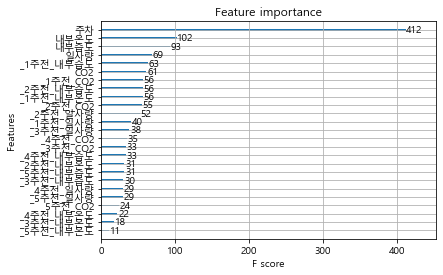

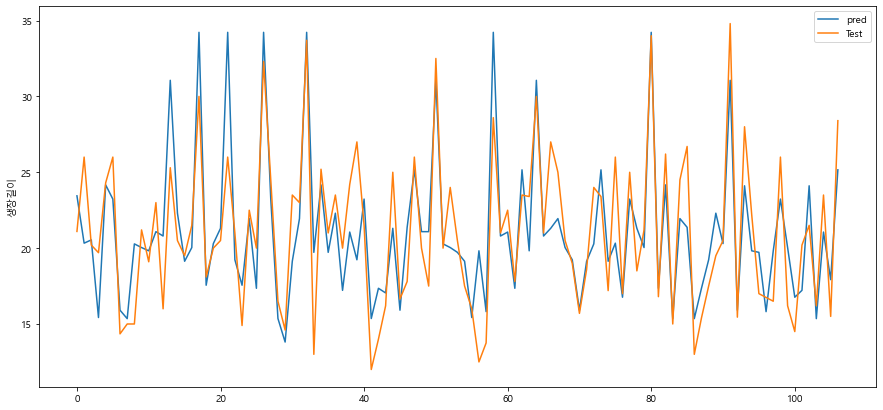

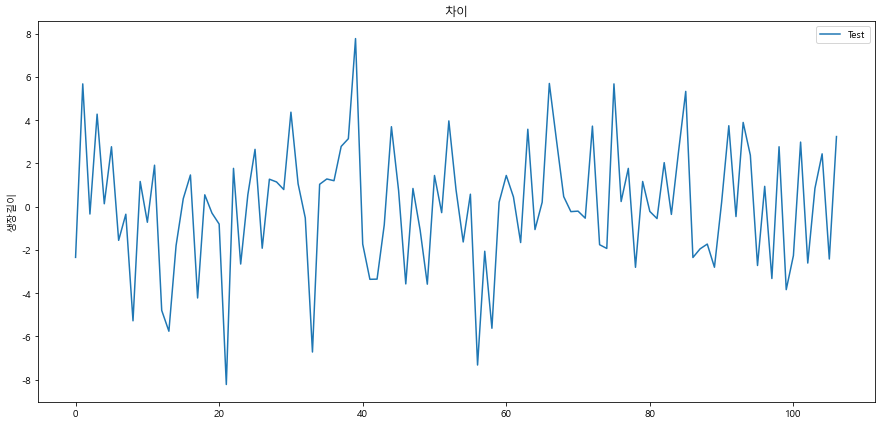

--------------------------------------------------------------------------------------------
--------------------------------------------------------------------------------------------
--------------------------------------------------------------------------------------------


2.910233751200524

In [147]:
parameters = {'eta':[0.07,0.1,0.13],
              'learning_rate':[0.08,0.1,0.13,0.15,0.17,0.2,0.3,0.6],
              'subsample':[0.7,0.8,0.9]}
result = xgb(model_dataset,'생장길이',parameters=parameters)
merge_dataset.iloc[result.index,:]

{'eta': 0.07, 'learning_rate': 0.13, 'subsample': 0.7}
318 107
2.79031767412507


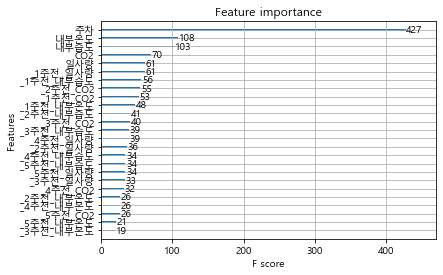

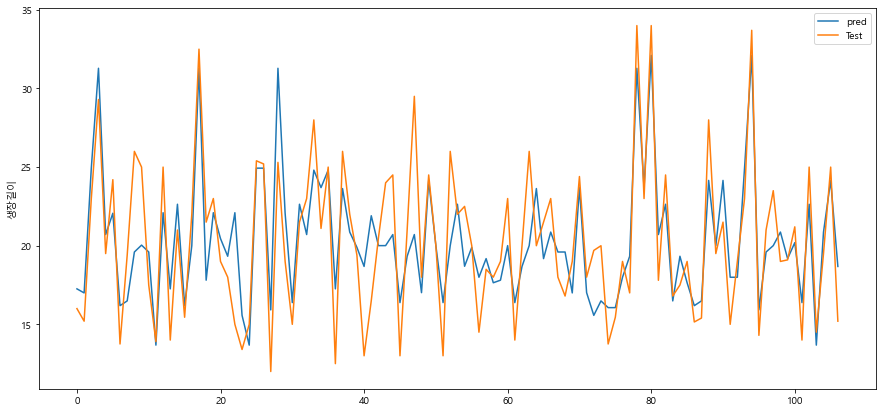

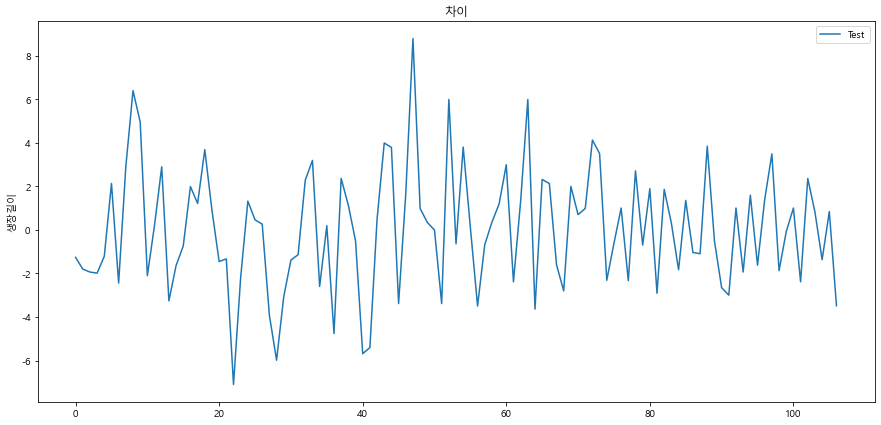

--------------------------------------------------------------------------------------------
--------------------------------------------------------------------------------------------
--------------------------------------------------------------------------------------------


2.79031767412507

In [148]:
parameters = {'eta':[0.07,0.1,0.13],
              'learning_rate':[0.08,0.1,0.13,0.15,0.17,0.2,0.3,0.6],
              'subsample':[0.7,0.8,0.9]}
result = xgb(model_dataset,'생장길이',parameters=parameters)
merge_dataset.iloc[result.index,:]

{'eta': 0.07, 'learning_rate': 0.13, 'subsample': 0.7}
318 107
2.9563935706035203


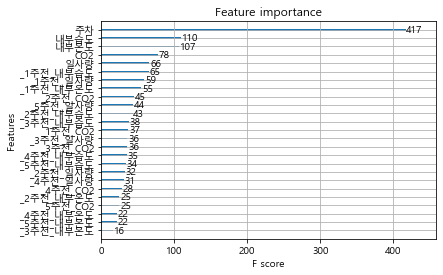

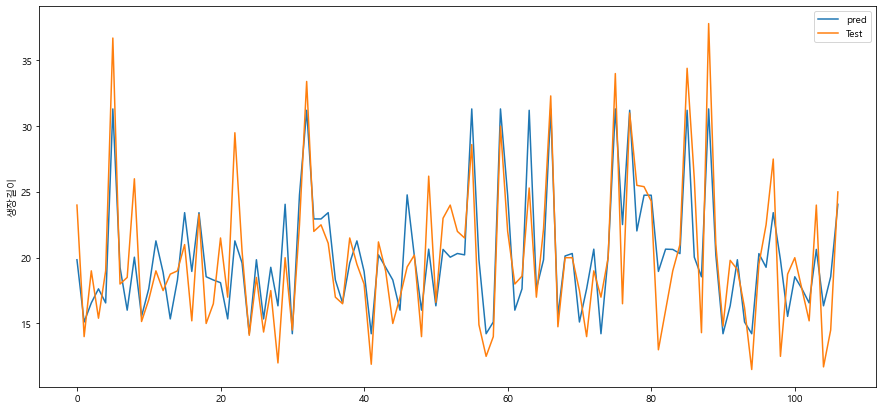

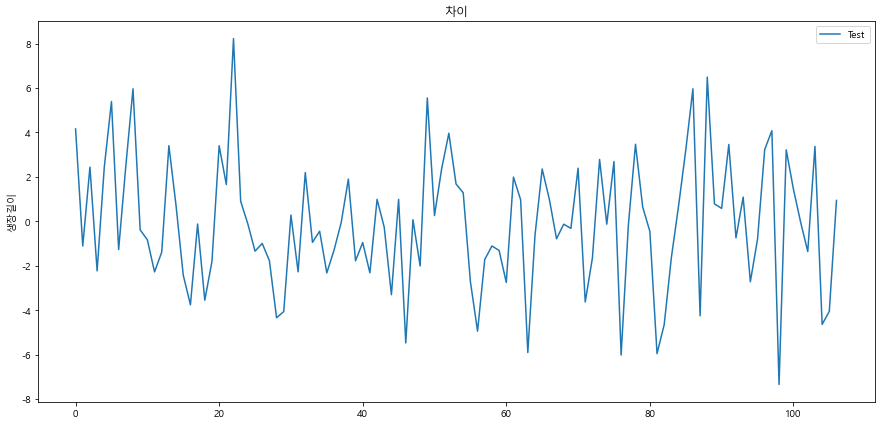

--------------------------------------------------------------------------------------------
--------------------------------------------------------------------------------------------
--------------------------------------------------------------------------------------------


2.9563935706035203

In [149]:
parameters = {'eta':[0.07,0.1,0.13],
              'learning_rate':[0.08,0.1,0.13,0.15,0.17,0.2,0.3,0.6],
              'subsample':[0.7,0.8,0.9]}
result = xgb(model_dataset,'생장길이',parameters=parameters)
merge_dataset.iloc[result.index,:]

# 수확과 데이터 없음.


샘플별 수확 갯수에 차이가 없다